In [1]:
packages <- c("tidyverse", "ggplot2", "stargazer", "rvest", "dplyr", "httr", "boot", "broom", "sandwich", "lmtest", "fixest", "Metrics")
invisible(lapply(packages, function(pkg) {
  if (!requireNamespace(pkg, quietly = TRUE)) install.packages(pkg)
  library(pkg, character.only = TRUE)
}))

Installing package into ‘/opt/homebrew/lib/R/4.4/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘sys’, ‘rematch’, ‘askpass’, ‘blob’, ‘DBI’, ‘data.table’, ‘gargle’, ‘cellranger’, ‘curl’, ‘ids’, ‘rematch2’, ‘openssl’, ‘timechange’, ‘systemfonts’, ‘textshaping’, ‘selectr’, ‘conflicted’, ‘dbplyr’, ‘dtplyr’, ‘googledrive’, ‘googlesheets4’, ‘httr’, ‘lubridate’, ‘modelr’, ‘ragg’, ‘readxl’, ‘reprex’, ‘rstudioapi’, ‘rvest’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Please cite as: 


 Hlavac, 

# 1. Data

## Function to scrape the data

In [2]:
scrape_page <- function(url) {
  response <- GET(url)
  if (status_code(response) != 200) {
    stop(paste("Failed to retrieve page:", url))
  }
  
  content <- content(response, "text")
  page <- read_html(content)
  include_element <- html_node(page, "[w3-include-html]")
  include_url <- html_attr(include_element, "w3-include-html")
  full_include_url <- paste0("https://ignaciomsarmiento.github.io/GEIH2018_sample/", include_url)
  
  included_content <- read_html(full_include_url)
  df_page <- html_node(included_content, "table") %>% html_table()
  
  return(df_page)
}

base_url <- "https://ignaciomsarmiento.github.io/GEIH2018_sample/page"
df_list <- lapply(1:10, function(i) {
  url <- paste0(base_url, i, ".html")
  df_page <- scrape_page(url)
  print(paste("Successfully scraped page", i))
  return(df_page)
})

# append dataframes
df <- do.call(rbind, df_list)

[1] "Successfully scraped page 1"
[1] "Successfully scraped page 2"
[1] "Successfully scraped page 3"
[1] "Successfully scraped page 4"
[1] "Successfully scraped page 5"
[1] "Successfully scraped page 6"
[1] "Successfully scraped page 7"
[1] "Successfully scraped page 8"
[1] "Successfully scraped page 9"
[1] "Successfully scraped page 10"


In [4]:
head(df, n = 10)

Var.1,directorio,secuencia_p,orden,clase,dominio,mes,estrato1,sex,age,⋯,y_viaticos_m,y_accidentes_m,y_salarySec_m,y_ingLab_m_ha,y_gananciaNeta_m,y_gananciaNetaAgro_m,y_gananciaIndep_m,y_gananciaIndep_m_hu,y_total_m,y_total_m_ha
<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4514331,1,2,1,BOGOTA,1,2,0,29,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,4514331,1,1,1,BOGOTA,1,2,1,36,⋯,NA,NA,NA,8404.320,NA,NA,NA,NA,1620833,8404.320
3,4514332,1,4,1,BOGOTA,1,2,1,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,4514332,1,3,1,BOGOTA,1,2,1,7,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,4514332,1,1,1,BOGOTA,1,2,0,32,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,4514332,1,2,1,BOGOTA,1,2,1,35,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
7,4514333,1,4,1,BOGOTA,1,2,1,18,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
8,4514333,1,2,1,BOGOTA,1,2,0,49,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
9,4514333,1,1,1,BOGOTA,1,2,1,51,⋯,NA,NA,NA,6703.343,NA,NA,NA,NA,1378973,6703.343


# 3. Age-Wage Profile Analysis

In [5]:
# subset --> >18 & occupied
df <- df[df$age > 18 & df$ocu == 1, ]
names(df) <- make.names(names(df), unique = TRUE) # set df names

# drop missing wages, log transform
df <- df %>%
  filter(!is.na(y_ingLab_m), !is.na(age)) %>%
  mutate(log_wage = log(y_ingLab_m + 1))


In [6]:
# 1. fit model-- OLS
model <- lm(log_wage ~ age + I(age^2), data = df)
print(summary(model))


Call:
lm(formula = log_wage ~ age + I(age^2), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.7449 -0.3833 -0.1060  0.3007  3.8503 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.238e+01  7.335e-02  168.73   <2e-16 ***
age          8.509e-02  3.878e-03   21.94   <2e-16 ***
I(age^2)    -9.880e-04  4.773e-05  -20.70   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7423 on 9782 degrees of freedom
Multiple R-squared:  0.05007,	Adjusted R-squared:  0.04988 
F-statistic: 257.8 on 2 and 9782 DF,  p-value: < 2.2e-16



In [7]:
# 2. Bootstrap
boot_fn <- function(data, indices) {
  d <- data[indices,]
  fit <- lm(log_wage ~ age + I(age^2), data = d)
  coef <- coef(fit)
  peak_age <- -coef[2] / (2 * coef[3])
  return(c(coef, peak_age = peak_age))
}
# peak age
calc_peak_age <- function(data, indices) {
  d <- data[indices,]
  model <- lm(log_wage ~ age + I(age^2), data = d)
  coef <- coef(model)
  peak_age <- -coef[2] / (2 * coef[3])
  return(peak_age)
}

In [8]:
# 3. do bootstrap
set.seed(555)
boot_results <- boot(data = df, statistic = boot_fn, R = 1000)

# 4. b_se
boot_se <- apply(boot_results$t, 2, sd)

# 5. reg table
stargazer(model, se = list(boot_se), type = "text", 
          title = "Age-Wage Profile Regression Results",
          column.labels = c("Coefficients", "Bootstrap SE"))



Age-Wage Profile Regression Results
                        Dependent variable:    
                    ---------------------------
                             log_wage          
                           Coefficients        
-----------------------------------------------
age                          0.085***          
                              (0.005)          
                                               
I(age2)                      -0.001***         
                             (0.0001)          
                                               
Constant                     12.376***         
                              (0.084)          
                                               
-----------------------------------------------
Observations                   9,785           
R2                             0.050           
Adjusted R2                    0.050           
Residual Std. Error      0.742 (df = 9782)     
F Statistic          257.797*** (df = 2; 9782) 
Not

In [9]:
# 6. peak age & CI's
original_peak_age <- -coef(model)[2] / (2 * coef(model)[3])
ci_peak <- quantile(boot_results$t[,4], c(0.025, 0.975))

cat("\nPeak Age Analysis:\n")
cat("Estimated Peak Age:", round(original_peak_age, 2), "\n")
cat("95% CI for Peak Age:", round(ci_peak[1], 2), "to", round(ci_peak[2], 2), "\n\n")



Peak Age Analysis:
Estimated Peak Age: 43.06 
95% CI for Peak Age: 42.26 to 43.98 



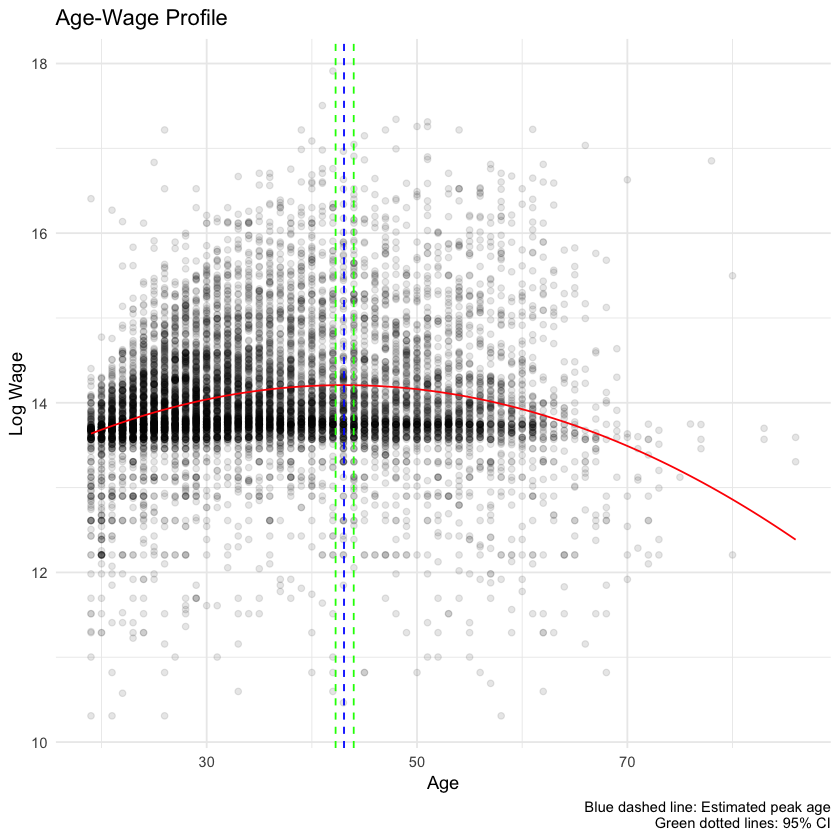

In [10]:
new_data <- data.frame(age = seq(min(df$age), max(df$age), length.out = 100))
new_data$predicted_log_wage <- predict(model, newdata = new_data)

ggplot(df, aes(x = age, y = log_wage)) +
  geom_point(alpha = 0.1) +
  geom_line(data = new_data, aes(y = predicted_log_wage), color = "red") +
  geom_vline(xintercept = original_peak_age, color = "blue", linetype = "dashed") + # nolint
  geom_vline(xintercept = ci_peak[1], color = "green", linetype = "dashed") +
  geom_vline(xintercept = ci_peak[2], color = "green", linetype = "dashed") +
  labs(title = "Age-Wage Profile",
       x = "Age", y = "Log Wage",
       caption = "Blue dashed line: Estimated peak age\nGreen dotted lines: 95% CI") + # nolint
  theme_minimal()


# 4. Gender Earnings GAP

In [11]:
model_gap <- lm(log_wage ~ sex, data = df)
robust_se <- vcovHC(model_gap, type = "HC1") # Heteroskedasticity-robust standard errors
robust_summary <- coeftest(model_gap, vcov = robust_se)
print(robust_summary)

# R/ Men earn on average 15.1% more than women in terms of wages. The effect is substantial, 
# suggesting a notable gender wage gap.


t test of coefficients:

             Estimate Std. Error   t value  Pr(>|t|)    
(Intercept) 13.948138   0.011551 1207.5540 < 2.2e-16 ***
sex          0.151050   0.015329    9.8536 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



## 4.1 Conditional Wage Gap (by FWL)

In [13]:
# Define control variables
controls <- c("age", "college", "formal", "oficio")

formula_controls <- as.formula(paste("log_wage ~", paste(controls, collapse = " + ")))
formula_controls_sex <- as.formula(paste("sex ~", paste(controls, collapse = " + ")))


In [14]:
# first we partial out the controls
residuals_y <- feols(formula_controls, data = df)$residuals
residuals_sex <- feols(formula_controls_sex, data = df)$residuals


The variables 'clase' and 'depto' have been removed because of collinearity (see $collin.var).

The variables 'clase' and 'depto' have been removed because of collinearity (see $collin.var).



In [15]:
# regress these residuals
fwl_model <- lm(residuals_y ~ residuals_sex)

# stats
fwl_coef <- coef(fwl_model)[2]
fwl_se <- sqrt(vcov(fwl_model)[2,2])
fwl_coef
fwl_se

residuals_sex 
    0.2535762

[1] 0.01275892

## 4.2 Conditional Wage Gap (by FWL) & Bootstrap

In [16]:
boot_fwl <- function(data, indices) {
  resid_y <- residuals_y[indices]
  resid_sex <- residuals_sex[indices]
  boot_model <- lm(resid_y ~ resid_sex)
  return(coef(boot_model)[2])
}

# bootstrap
set.seed(555)
boot_results <- boot(data = df, statistic = boot_fwl, R = 1000)

# bootstrap standard error
boot_se <- sd(boot_results$t)

In [17]:
cat("Frisch-Waugh-Lovell Theorem Results:\n")
cat("Coefficient:", fwl_coef, "\n")
cat("Standard Error (Normal):", fwl_se, "\n")
cat("Standard Error (Bootstrap):", boot_se, "\n")

Frisch-Waugh-Lovell Theorem Results:
Coefficient: 0.2535762 
Standard Error (Normal): 0.01275892 
Standard Error (Bootstrap): 0.01292994 


## 4.3 Age-Wage Profile by Gender

In [18]:
model <- lm(log_wage ~ sex * (age + I(age^2)), data = df)
print(summary(model))


Call:
lm(formula = log_wage ~ sex * (age + I(age^2)), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.6367 -0.3631 -0.1103  0.2968  3.8070 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.241e+01  1.039e-01 119.425   <2e-16 ***
sex          -1.258e-01  1.453e-01  -0.865    0.387    
age           8.456e-02  5.480e-03  15.429   <2e-16 ***
I(age^2)     -1.050e-03  6.758e-05 -15.544   <2e-16 ***
sex:age       4.765e-03  7.685e-03   0.620    0.535    
sex:I(age^2)  7.944e-05  9.457e-05   0.840    0.401    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7348 on 9779 degrees of freedom
Multiple R-squared:  0.06942,	Adjusted R-squared:  0.06894 
F-statistic: 145.9 on 5 and 9779 DF,  p-value: < 2.2e-16



In [20]:
# 2. Bootstrap function
boot_fn <- function(data, indices) {
  d <- data[indices,]
  fit <- lm(log_wage ~ sex * (age + I(age^2)), data = d)
  coef <- coef(fit)
  peak_age_male <- -coef["age"] / (2 * coef["I(age^2)"])
  peak_age_female <- -(coef["age"] + coef["sex:age"]) / (2 * (coef["I(age^2)"] + coef["sex:I(age^2)"]))
  return(c(peak_age_male, peak_age_female))
}

set.seed(555)
boot_results <- boot(data = df, statistic = boot_fn, R = 1000)


In [21]:
# 4. Bootstrap SE for model coefficients
coef_boot_fn <- function(data, indices) {
  d <- data[indices,]
  fit <- lm(log_wage ~ sex * (age + I(age^2)), data = d)
  return(coef(fit))
}
coef_boot_results <- boot(data = df, statistic = coef_boot_fn, R = 1000)
boot_se <- apply(coef_boot_results$t, 2, sd)

In [22]:
stargazer(model, se = list(boot_se), type = "text", 
          title = "Age-Wage Profile Regression Results",
          column.labels = c("Coefficients", "Bootstrap SE"))

# 6. Peak age & CI's
original_peak_age_male <- -coef(model)["age"] / (2 * coef(model)["I(age^2)"])
original_peak_age_female <- -(coef(model)["age"] + coef(model)["sex:age"]) / 
  (2 * (coef(model)["I(age^2)"] + coef(model)["sex:I(age^2)"]))

ci_peak_male <- quantile(boot_results$t[, 1], c(0.025, 0.975))
ci_peak_female <- quantile(boot_results$t[, 2], c(0.025, 0.975))

cat("\nPeak Age Analysis:\n")
cat("Estimated Peak Age (Male):", round(original_peak_age_male, 2), "\n")
cat("95% CI for Peak Age (Male):", round(ci_peak_male[1], 2), "to", round(ci_peak_male[2], 2), "\n")
cat("Estimated Peak Age (Female):", round(original_peak_age_female, 2), "\n")
cat("95% CI for Peak Age (Female):", round(ci_peak_female[1], 2), "to", round(ci_peak_female[2], 2), "\n\n")



Age-Wage Profile Regression Results
                        Dependent variable:    
                    ---------------------------
                             log_wage          
                           Coefficients        
-----------------------------------------------
sex                           -0.126           
                              (0.164)          
                                               
age                          0.085***          
                              (0.007)          
                                               
I(age2)                      -0.001***         
                             (0.0001)          
                                               
sex:age                        0.005           
                              (0.009)          
                                               
sex:I(age2)                   0.0001           
                             (0.0001)          
                                               
Con

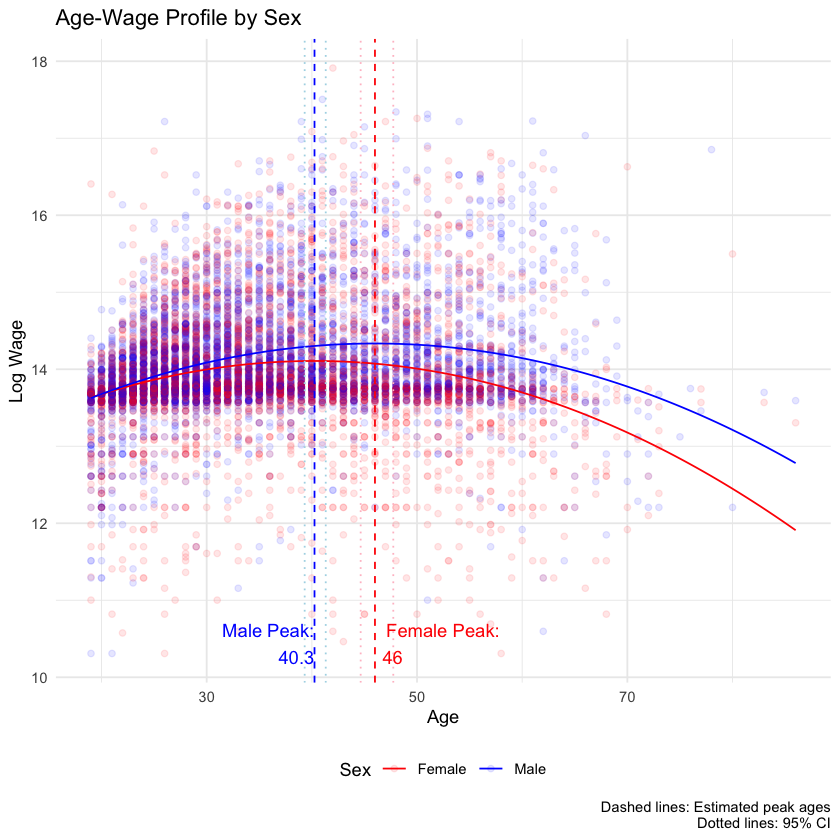

In [23]:
new_data <- expand.grid(
  age = seq(min(df$age), max(df$age), length.out = 100),
  sex = c(0, 1)  # Keep as numeric
)
new_data$predicted_log_wage <- predict(model, newdata = new_data)

# labels for peak ages
male_peak_label <- paste("Male Peak:\n", round(original_peak_age_male, 1))
female_peak_label <- paste("Female Peak:\n", round(original_peak_age_female, 1))

ggplot(df, aes(x = age, y = log_wage, color = factor(sex))) +
  geom_point(alpha = 0.1) +
  geom_line(data = new_data, aes(y = predicted_log_wage, color = factor(sex))) +
  geom_vline(xintercept = original_peak_age_male, color = "blue", linetype = "dashed") +
  geom_vline(xintercept = original_peak_age_female, color = "red", linetype = "dashed") +
  geom_vline(xintercept = ci_peak_male[1], color = "lightblue", linetype = "dotted") +
  geom_vline(xintercept = ci_peak_male[2], color = "lightblue", linetype = "dotted") +
  geom_vline(xintercept = ci_peak_female[1], color = "pink", linetype = "dotted") +
  geom_vline(xintercept = ci_peak_female[2], color = "pink", linetype = "dotted") +
  # labels for peak ages
  annotate("text", x = original_peak_age_male, y = max(df$log_wage), 
           label = male_peak_label, color = "blue", vjust = 15, hjust = 1) +
  annotate("text", x = original_peak_age_female, y = max(df$log_wage), 
           label = female_peak_label, color = "red", vjust = 15, hjust = -0.1) +
  labs(title = "Age-Wage Profile by Sex",
       x = "Age", y = "Log Wage",
       color = "Sex",  # Change legend title
       caption = "Dashed lines: Estimated peak ages\nDotted lines: 95% CI") +
  scale_color_manual(values = c("0" = "red", "1" = "blue"), 
                     labels = c("0" = "Female", "1" = "Male")) +  
  theme_minimal() +
  theme(legend.position = "bottom")


# 5. Predicting Earnings

In [24]:
set.seed(10101)

In [25]:
# 70-30m split
train_indices <- sample(seq_len(nrow(df)), size = 0.7 * nrow(df))
train_data <- df[train_indices, ]
test_data <- df[-train_indices, ]

In [35]:
#TODO: add more features
sapply(train_data[, c("age", "oficio")], function(x) length(unique(x)))

# why does clase and depto have only one unique value?

age oficio 
    62     75

In [37]:
# Model 1: Basic model with age and oficio, including interaction
model1 <- lm(log_wage ~ age * oficio, data = train_data)

# Model 2: Polynomial terms for age, and oficio
model2 <- lm(log_wage ~ poly(age, 3) + oficio, data = train_data)

# Model 3: Interaction between age and oficio with polynomial term for age
model3 <- lm(log_wage ~ poly(age, 3) * oficio, data = train_data)

# Model 4: Including quadratic term for age and interaction with oficio
model4 <- lm(log_wage ~ age + I(age^2) + oficio + age:oficio, data = train_data)

# Model 5: Full model with cubic polynomial for age and interaction with oficio
model5 <- lm(log_wage ~ poly(age, 3) * oficio + I(age^3), data = train_data)



In [38]:
# RMSE function
compute_rmse <- function(model, data) {
  predictions <- predict(model, newdata = data)
  return(rmse(data$log_wage, predictions))
}

# Calculate RMSE for each model
rmse_model1 <- compute_rmse(model1, test_data)
rmse_model2 <- compute_rmse(model2, test_data)
rmse_model3 <- compute_rmse(model3, test_data)
rmse_model4 <- compute_rmse(model4, test_data)
rmse_model5 <- compute_rmse(model5, test_data)

# Compare RMSEs
rmse_results <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  RMSE = c(rmse_model1, rmse_model2, rmse_model3, rmse_model4, rmse_model5)
)

print(rmse_results)


    Model      RMSE
1 Model 1 0.6833711
2 Model 2 0.6747988
3 Model 3 0.6671316
4 Model 4 0.6691376
5 Model 5 0.6671316


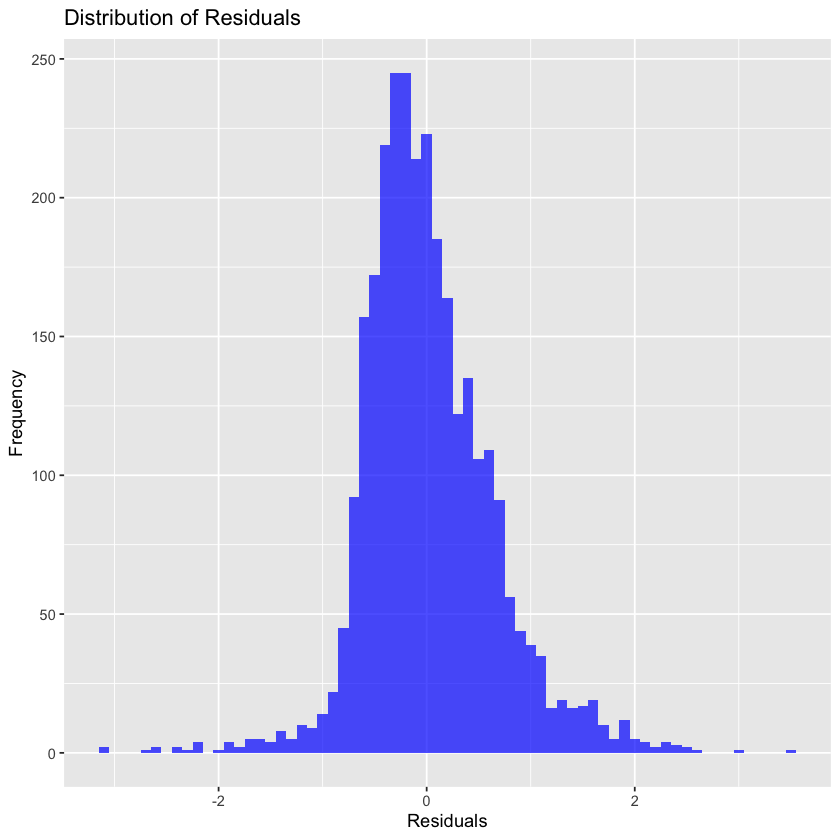

In [30]:
# residuals for the best model
best_model <- model5 
test_data$residuals <- test_data$log_wage - predict(best_model, newdata = test_data)

ggplot(test_data, aes(x = residuals)) +
  geom_histogram(binwidth = 0.1, fill = "blue", alpha = 0.7) +
  labs(title = "Distribution of Residuals",
       x = "Residuals", y = "Frequency")
